In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
from tqdm import tqdm

path = '../input'
train_csv = os.path.join(path, 'train.csv')
train = pd.read_csv(train_csv)
print(train.head())
categories = train.groupby('Id').size()
#print(categories.sort_values())
#new_whale has 9664 pictures
#otherwise, there is only one picture for learning, such as w_0003639.

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [3]:
# Make Categories dictionary
Id_dict = {}

for i, id in enumerate(categories.index):
    if id in Id_dict:
        continue
    Id_dict[id] = i

print('Number of categories of Whale: {}'.format(len(Id_dict)))

Id_to_num = []
for id in tqdm(train.Id):
    Id_to_num.append(Id_dict[id])

100%|██████████| 25361/25361 [00:00<00:00, 1616198.85it/s]

Number of categories of Whale: 5005


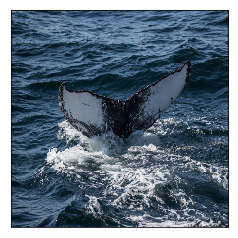

In [4]:
import cv2
import matplotlib.pyplot as plt

def read_images(image_name):
    base_size = 224
    path = '../input/train'
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (base_size, base_size))
    
    return img
    
#For test
img = read_images('0000e88ab.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
img_data = []

for img_name in tqdm(train.Image):
    img = read_images(img_name)
    img_data.append(img)

print(len(img_data))
train['Image_Data'] = img_data
train['Id_to_num'] = Id_to_num

del img_data
del Id_to_num

100%|██████████| 25361/25361 [03:37<00:00, 116.40it/s]

25361


In [6]:
from sklearn.model_selection import train_test_split

train_data, vaild_data = train_test_split(train, test_size=0.1, random_state=2018)
print(train_data.head())
print(vaild_data.head())

del train

               Image    ...    Id_to_num
10182  670d308f6.jpg    ...         2713
12421  7dadaa49f.jpg    ...         4141
1544   0f6de2175.jpg    ...         2778
9568   60eae9ed2.jpg    ...            0
17749  b20e66aa4.jpg    ...           41

[5 rows x 4 columns]
               Image    ...    Id_to_num
10168  66ee1433e.jpg    ...         1028
10046  65c1c4693.jpg    ...         2435
20004  c96beee45.jpg    ...            0
13351  869137af0.jpg    ...         4038
13158  84b12af51.jpg    ...         3736

[5 rows x 4 columns]


In [7]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Input, GlobalAvgPool2D, Dense, Dropout
from keras import metrics
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

model = MobileNetV2(input_shape=(224, 224, 3),  include_top=True, weights=None, classes=len(Id_dict))
model.compile(optimizer= optimizers.Adam(lr=0.001),loss='categorical_crossentropy', 
              metrics=[metrics.categorical_accuracy])
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [8]:
from keras.utils import to_categorical

X_train, y_train = np.asarray(list(train_data.Image_Data)), train_data.Id_to_num
X_test, y_test = np.asarray(list(vaild_data.Image_Data)), vaild_data.Id_to_num
y_train = to_categorical(y_train, num_classes=len(Id_dict))
y_test = to_categorical(y_test, num_classes=len(Id_dict))

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)

del train_data, vaild_data

(22824, 5005)
(2537, 5005)
(22824, 224, 224, 3)


In [ ]:
traingen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
testgen = ImageDataGenerator(rescale=1./255)

In [ ]:
model.fit_generator(traingen.flow(X_train, y_train, batch_size=16), steps_per_epoch=X_train.shape[0]/16, epochs=100)